# Compute  PCA : Method 1 : Clustering

- use PCA scikit learn from scikit learn

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/12/28
- update : 2022/12/28

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from mpl_toolkits.mplot3d import axes3d  

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice
import itertools

from astroML.utils.decorators import pickle_results


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [4]:
from astropy.io import fits
import copy

In [5]:
filename = "datatools/pcamethod1_SL_eigenvectorandcoeff.fits"
hdu = fits.open(filename)

In [6]:
hdu.info()

Filename: datatools/pcamethod1_SL_eigenvectorandcoeff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   (6362, 553)   float64   
  1                1 ImageHDU         8   (10, 550)   float64   
  2                1 ImageHDU         8   (6361, 10)   float64   


In [7]:
data1=hdu[0].data
hdr1 = hdu[0].header
hdr1

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6362                                                  
NAXIS2  =                  553                                                  
EXTEND  =                    T                                                  
DATAWLS = 'data[0,1:]'                                                          
DATALLAV= 'data[1,1:]'                                                          
DATALLST= 'data[2,1:]'                                                          
DATAFL  = 'data[3:,1:]'                                                         
DATANUM = 'data[3:,0]'                                                          
COMMENT Spectra of StarLight                                                    

In [8]:
data2=hdu[1].data
hdr2 = hdu[1].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   10                                                  
NAXIS2  =                  550                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 spectra coefficients                                       

In [9]:
data3=hdu[2].data
hdr2 = hdu[2].header
hdr2

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6361                                                  
NAXIS2  =                   10                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
COMMENT PCA method 1 Eigen Vectors                                              

In [10]:
NSED = data1.shape[0]-3
NWL = data1.shape[1]-1

In [11]:
wavelengths = data1[0,1:] 
flambdas_average = data1[1,1:] 
flambdas_std = data1[2,1:] 
spec = data1[3:,1:] 
all_numbers = data1[3:,0] 

In [12]:
#flux = dfluxnorm*flambdas_std +  flambdas_average

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_30047/1659706449.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

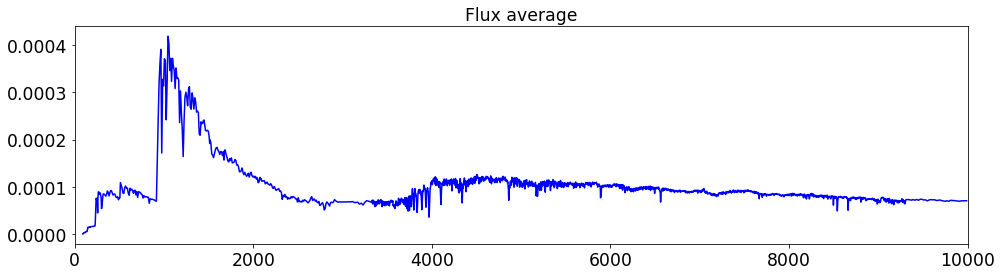

In [13]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

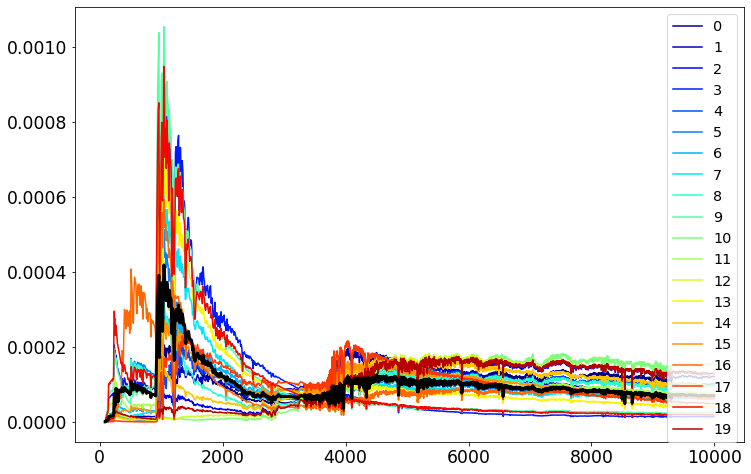

In [14]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    plt.plot(wavelengths,spec[idx,:],color=all_colors[idx],label=str(idx))

plt.legend()
spec_mean = spec.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=3)
#plt.ylim(0,50.)

# Clustering

https://scikit-learn.org/stable/modules/clustering.html

## Clustering from PCA coefficients

In [15]:
X = copy.deepcopy(data2)

In [16]:
X.shape

(550, 10)

In [17]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix


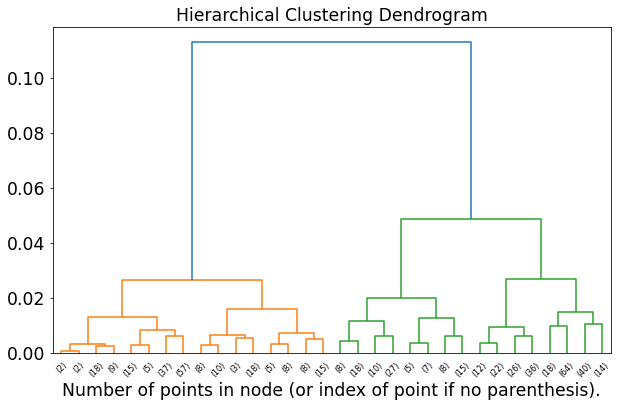

In [18]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
#model = AgglomerativeClustering(distance_threshold=0, n_clusters=30)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
matrix = plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


https://stackoverflow.com/questions/27386641/how-to-traverse-a-tree-from-sklearn-agglomerativeclustering

In [19]:
dict(enumerate(model.children_, model.n_leaves_))

{550: array([156, 342]),
 551: array([364, 375]),
 552: array([ 97, 550]),
 553: array([340, 341]),
 554: array([422, 513]),
 555: array([146, 149]),
 556: array([ 68, 488]),
 557: array([ 86, 284]),
 558: array([ 78, 546]),
 559: array([287, 332]),
 560: array([200, 453]),
 561: array([326, 558]),
 562: array([ 87, 324]),
 563: array([220, 327]),
 564: array([357, 523]),
 565: array([ 84, 192]),
 566: array([279, 531]),
 567: array([426, 499]),
 568: array([484, 556]),
 569: array([ 10, 565]),
 570: array([155, 527]),
 571: array([144, 304]),
 572: array([557, 562]),
 573: array([ 57, 405]),
 574: array([ 19, 337]),
 575: array([ 99, 448]),
 576: array([487, 490]),
 577: array([477, 561]),
 578: array([259, 424]),
 579: array([313, 322]),
 580: array([464, 549]),
 581: array([ 12, 252]),
 582: array([221, 325]),
 583: array([465, 479]),
 584: array([348, 349]),
 585: array([108, 385]),
 586: array([150, 330]),
 587: array([481, 529]),
 588: array([ 90, 496]),
 589: array([328, 333]),


In [20]:
ii = itertools.count(X.shape[0])
[{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

[{'node_id': 550, 'left': 156, 'right': 342},
 {'node_id': 551, 'left': 364, 'right': 375},
 {'node_id': 552, 'left': 97, 'right': 550},
 {'node_id': 553, 'left': 340, 'right': 341},
 {'node_id': 554, 'left': 422, 'right': 513},
 {'node_id': 555, 'left': 146, 'right': 149},
 {'node_id': 556, 'left': 68, 'right': 488},
 {'node_id': 557, 'left': 86, 'right': 284},
 {'node_id': 558, 'left': 78, 'right': 546},
 {'node_id': 559, 'left': 287, 'right': 332},
 {'node_id': 560, 'left': 200, 'right': 453},
 {'node_id': 561, 'left': 326, 'right': 558},
 {'node_id': 562, 'left': 87, 'right': 324},
 {'node_id': 563, 'left': 220, 'right': 327},
 {'node_id': 564, 'left': 357, 'right': 523},
 {'node_id': 565, 'left': 84, 'right': 192},
 {'node_id': 566, 'left': 279, 'right': 531},
 {'node_id': 567, 'left': 426, 'right': 499},
 {'node_id': 568, 'left': 484, 'right': 556},
 {'node_id': 569, 'left': 10, 'right': 565},
 {'node_id': 570, 'left': 155, 'right': 527},
 {'node_id': 571, 'left': 144, 'right': 3

In [21]:
ii = itertools.count(X.shape[0])
clusters = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

import copy
n_points = X.shape[0]
members = {i:[i] for i in range(n_points)}
for cluster in clusters:
    node_id = cluster["node_id"]
    members[node_id] = copy.deepcopy(members[cluster["left"]])
    members[node_id].extend(copy.deepcopy(members[cluster["right"]]))

on_split = {c["node_id"]: [c["left"], c["right"]] for c in clusters}
up_merge = {c["left"]: {"into": c["node_id"], "with": c["right"]} for c in clusters}
up_merge.update({c["right"]: {"into": c["node_id"], "with": c["left"]} for c in clusters})

In [22]:
print(on_split)

{550: [156, 342], 551: [364, 375], 552: [97, 550], 553: [340, 341], 554: [422, 513], 555: [146, 149], 556: [68, 488], 557: [86, 284], 558: [78, 546], 559: [287, 332], 560: [200, 453], 561: [326, 558], 562: [87, 324], 563: [220, 327], 564: [357, 523], 565: [84, 192], 566: [279, 531], 567: [426, 499], 568: [484, 556], 569: [10, 565], 570: [155, 527], 571: [144, 304], 572: [557, 562], 573: [57, 405], 574: [19, 337], 575: [99, 448], 576: [487, 490], 577: [477, 561], 578: [259, 424], 579: [313, 322], 580: [464, 549], 581: [12, 252], 582: [221, 325], 583: [465, 479], 584: [348, 349], 585: [108, 385], 586: [150, 330], 587: [481, 529], 588: [90, 496], 589: [328, 333], 590: [240, 566], 591: [24, 180], 592: [201, 388], 593: [389, 583], 594: [165, 233], 595: [137, 355], 596: [246, 578], 597: [239, 370], 598: [568, 588], 599: [105, 229], 600: [379, 580], 601: [69, 559], 602: [439, 471], 603: [288, 475], 604: [564, 567], 605: [473, 579], 606: [40, 59], 607: [280, 503], 608: [560, 593], 609: [393, 5

In [23]:
print(up_merge)

{156: {'into': 550, 'with': 342}, 364: {'into': 551, 'with': 375}, 97: {'into': 552, 'with': 550}, 340: {'into': 553, 'with': 341}, 422: {'into': 554, 'with': 513}, 146: {'into': 555, 'with': 149}, 68: {'into': 556, 'with': 488}, 86: {'into': 557, 'with': 284}, 78: {'into': 558, 'with': 546}, 287: {'into': 559, 'with': 332}, 200: {'into': 560, 'with': 453}, 326: {'into': 561, 'with': 558}, 87: {'into': 562, 'with': 324}, 220: {'into': 563, 'with': 327}, 357: {'into': 564, 'with': 523}, 84: {'into': 565, 'with': 192}, 279: {'into': 566, 'with': 531}, 426: {'into': 567, 'with': 499}, 484: {'into': 568, 'with': 556}, 10: {'into': 569, 'with': 565}, 155: {'into': 570, 'with': 527}, 144: {'into': 571, 'with': 304}, 557: {'into': 572, 'with': 562}, 57: {'into': 573, 'with': 405}, 19: {'into': 574, 'with': 337}, 99: {'into': 575, 'with': 448}, 487: {'into': 576, 'with': 490}, 477: {'into': 577, 'with': 561}, 259: {'into': 578, 'with': 424}, 313: {'into': 579, 'with': 322}, 464: {'into': 580, 

In [24]:
matrix.shape

(549, 4)

In [25]:
matrix

array([[1.56000000e+02, 3.42000000e+02, 2.90082341e-16, 2.00000000e+00],
       [3.64000000e+02, 3.75000000e+02, 3.70946784e-16, 2.00000000e+00],
       [9.70000000e+01, 5.50000000e+02, 6.43277616e-16, 3.00000000e+00],
       ...,
       [1.08600000e+03, 1.09200000e+03, 2.67119666e-02, 2.32000000e+02],
       [1.09400000e+03, 1.09600000e+03, 4.87810561e-02, 3.30000000e+02],
       [1.09500000e+03, 1.09700000e+03, 1.12880301e-01, 5.50000000e+02]])

In [26]:
model.n_leaves_

550

In [27]:
model.children_.shape

(549, 2)

In [28]:
model.distances_.shape

(549,)

### Clustering from Spectra

In [32]:
X = copy.deepcopy(spec)

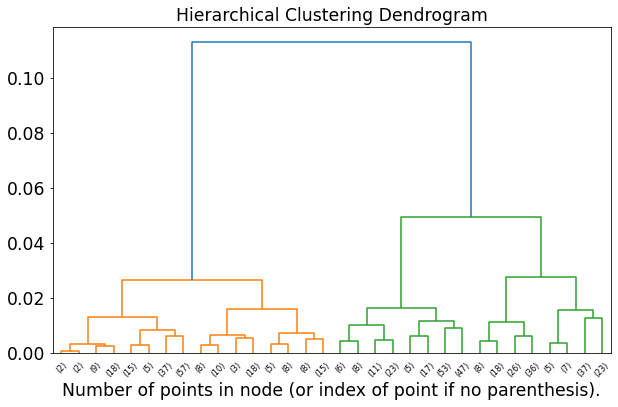

In [30]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [31]:
ii = itertools.count(X.shape[0])
clusters = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

import copy
n_points = X.shape[0]
members = {i:[i] for i in range(n_points)}
for cluster in clusters:
    node_id = cluster["node_id"]
    members[node_id] = copy.deepcopy(members[cluster["left"]])
    members[node_id].extend(copy.deepcopy(members[cluster["right"]]))

on_split = {c["node_id"]: [c["left"], c["right"]] for c in clusters}
up_merge = {c["left"]: {"into": c["node_id"], "with": c["right"]} for c in clusters}
up_merge.update({c["right"]: {"into": c["node_id"], "with": c["left"]} for c in clusters})